# Demonstration of the IIR module capabilities

In [1]:
# Change the host name and configuration to suit your environment!
HOSTNAME = 'rp-f0bd75'
CONFIG = 'basic.filters'

In [2]:
import pyrpl
p = pyrpl.Pyrpl(config = CONFIG, hostname = HOSTNAME, gui = False)

In [3]:
# create short cuts to the infinite impulse response and network analyser modules
iir = p.rp.iir
na = p.networkanalyzer

In a simple RC low pass filter there is a relationship between the time constant

$\tau = RC$

and the cut off frequency ($f_c$) of the low pass filter

$f_c = \displaystyle{1\over 2 \pi\tau}$

So either may be specified.  Here we choose to specify the desired cut off frequency of the
low pass filter that we are designing

In [4]:
TC = None
fc = 1.59235e6

In [5]:
import numpy as np
if TC is not None:
    fc = 1 / (2 * np.pi * TC)

The decimation factor of the infinite impulse response module is called "loops". Loops must be greater than 3 and less than 1024, thus defining the range of allowed cut off frequencies between 122KHz to 41.6MHz (3.8ns < $\tau$ <1.3us)

In [6]:
loops = round(125e6 / fc)

In [7]:
if 1023 < loops:
    loops = 1023
    print('frequency / time constant not possible - adjusted')
if loops < 3:
    loops = 3
    print('frequency / time constant not possible - adjusted')

In [8]:
fs = 125e6 / loops
fc = 125e6 / loops
TC = 1 / (2 * np.pi * fc)

The transfer function of a simple low pass filter is defined as

${v_o\over v_i} = {1\over 1 + j2\pi f RC}$

Define the angular frequency as $\omega = 2\pi f$, simply this expression to

${v_o\over v_i} = {1\over 1 + j\omega\tau} = {1 - j\omega\tau\over 1 + \omega^2\tau^2}$

Further define the angular frequency at the cut off frequency as $\omega_c = {1\over\tau}$ then we can see from the complex expression that the phase of the output signal will be at $-45^\circ$ to the input signal at the cut off frequency.

Notice also that if $j\omega = - {1\over\tau}$ then the transfer function becomes infinite.  Putting this another way there is a pole at $-\omega_c$.

In the case of a high pass filter the numerator has a multiple of $\omega$.  In that case the transfer function has an additional zero at $\omega = 0$.

In [9]:
omegac = 2 * np.pi * fc / fs

In [10]:
zeros = []
poles = [ fc * complex( -1, 0 ) ]

In [11]:
# now define the gain of the filter, chosen so that the FPGA values do not saturate
gain = 1e-9

In [12]:
iir.setup(gain = gain,
          zeros = zeros, poles = poles,
          loops = loops)

In [13]:
# the sampling frequency for the iir filter is considered later.  This is defined as
print('Filter sampling frequency: {:0.3f} MHz'.format(125. / iir.loops))

Filter sampling frequency: 1.582 MHz


In [14]:
# useful diagnostic functions
print('IIR on: {}'.format(iir.on))
print('IIR bypassed: {}'.format(iir.bypass))
print('IIR loops: {} requested: {}'.format(iir.loops, loops))
print('IIR overflows: {}'.format(iir.overflow))
print('Coefficients (6 per biquad)\n{}'.format(iir.coefficients))

IIR on: True
IIR bypassed: False
IIR loops: 79 requested: 79
IIR overflows: no overflow
Coefficients (6 per biquad)
[[ 0.00994175  0.          0.          1.         -0.00186744 -0.        ]
 [ 0.          0.          0.          1.         -0.         -0.        ]
 [ 0.          0.          0.          1.         -0.         -0.        ]
 [ 0.          0.          0.          1.         -0.         -0.        ]
 [ 0.          0.          0.          1.         -0.         -0.        ]
 [ 0.          0.          0.          1.         -0.         -0.        ]
 [ 0.          0.          0.          1.         -0.         -0.        ]
 [ 0.          0.          0.          1.         -0.         -0.        ]
 [ 0.          0.          0.          1.         -0.         -0.        ]
 [ 0.          0.          0.          1.         -0.         -0.        ]
 [ 0.          0.          0.          1.         -0.         -0.        ]
 [ 0.          0.          0.          1.         -0.      

In [15]:
# check that the filter is ok before measuring the transfer function
print('IIR overflows before: {}'.format(iir.overflow))

IIR overflows before: no overflow


In [16]:
# using the network analyser module we can measure the transfer function
# first set the cutoff frequency used in the iq low-pass filter (bandwidth)
# and the number of frequency points in the output transfer function
rbw = 1000
points = 1001

In [17]:
# now step through the frequencies and measure the tranfer function
stop_freq = 3e7
iir.input = na.iq
na.setup(start_freq = 1e4, stop_freq = stop_freq, rbw = rbw,
         points = points,
         average_per_point = 1,
         amplitude = 0.1,
         input = 'iir', output_direct = 'off',
         logscale=True)

In [18]:
tf = na.single()

In [19]:
# check that the filter is still ok after measuring the transfer function
print('IIR overflows after: {}'.format(iir.overflow))

IIR overflows after: no overflow


In [20]:
phases = np.angle(tf, deg=True)
phases = phases - phases[0]
condition = phases < -45
idxs = np.where(condition)
fminpidx = idxs[0].min()
dbs = 20 * np.log10(np.abs(tf))
dbs = dbs - dbs.max()
condition = dbs < -3
idxs = np.where(condition)
fmindidx = idxs[0].min()

In [21]:
print('frequency: {:0.0f} relative magnitude: {:0.3f} dB phase: {:0.3f} degrees'.format(
    na.frequencies[fminpidx], dbs[fminpidx], phases[fminpidx]))
print('frequency: {:0.0f} relative magnitude: {:0.3f} dB phase: {:0.3f} degrees'.format(
    na.frequencies[fmindidx], dbs[fmindidx], phases[fmindidx]))

frequency: 355464 relative magnitude: -0.736 dB phase: -45.017 degrees
frequency: 696425 relative magnitude: -3.036 dB phase: -89.160 degrees


In [22]:
designdata = iir.transfer_function(na.frequencies)

In [23]:
# Now plot the design data and the measured response
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 6)

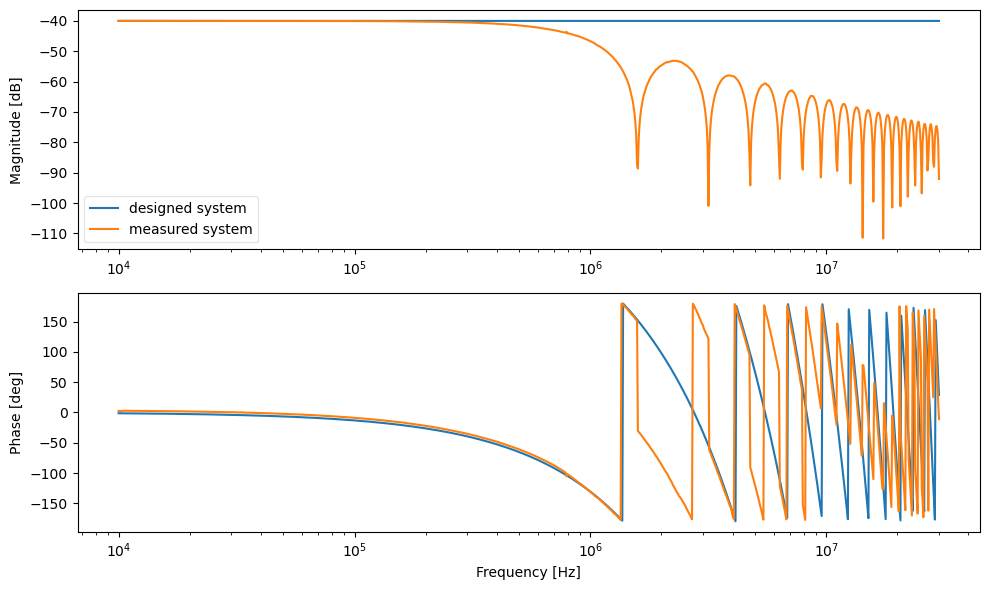

In [24]:
from pyrpl.hardware_modules.iir.iir_theory import bodeplot
bodeplot([(na.frequencies, designdata, 'designed system'),
          (na.frequencies, tf, 'measured system')], xlog=True)

Note that when running the python3 equivalent script the bodeplot produced allows you to move the cursor to points of interest on the graphs and the read-out provides the measured frequency / phase or magnitude at the cursor position.  This allows you to measure for example the first order drop off rate of 20dB per decade of frequency.

# Improving the filter performance

Notice that in the above example the sampling frequency ($125\over \text{loops}$) is the same as $f_c$.  As a result the role off rate does not look very smooth.  We can improve on this role off rate by increasing the number of samples.  We do this with a new parameter "samples".  The value of this new parameter depends on the selected $f_c$ and the type of filter that we choose to design.

In [25]:
fc = 1.5e5

In [26]:
samples = 104
loops = round(125e6 / (samples * fc))

In [27]:
if 1023 < loops:
    loops = 1023
    print('frequency / time constant not possible - adjusted')
if loops < 3:
    loops = 3
    print('frequency / time constant not possible - adjusted')

In [28]:
fs = 125e6 / loops
fc = 125e6 / (samples * loops)
TC = 1 / (2 * np.pi * fc)
omegac = 2 * np.pi * fc / fs

In [29]:
zeros = []
poles = [ fc * complex( -1, 0 ) ]

In [30]:
gain = 1e-9
iir.setup(gain = gain,
          zeros = zeros, poles = poles,
          loops = loops)

In [31]:
# The new sampling frequency is higher than fc
print('Filter sampling frequency: {:0.3f} MHz cut off frequency: {:0.3f} MHz'.format(
    125. / iir.loops, fc / 1e6))

Filter sampling frequency: 15.625 MHz cut off frequency: 0.150 MHz


In [32]:
print('IIR loops: {} requested: {}'.format(iir.loops, loops))
print('Coefficients (6 per biquad)\n{}'.format(iir.coefficients))

IIR loops: 8 requested: 8
Coefficients (6 per biquad)
[[ 9.43988562e-04  0.00000000e+00  0.00000000e+00  1.00000000e+00
  -9.41373553e-01 -0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  -0.00000000e+00 -0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  -0.00000000e+00 -0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  -0.00000000e+00 -0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  -0.00000000e+00 -0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  -0.00000000e+00 -0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  -0.00000000e+00 -0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  -0.00000000e+00 -0.00000000e+00]]


In [33]:
# check that the filter is ok before measuring the transfer function
print('IIR overflows before: {}'.format(iir.overflow))

IIR overflows before: no overflow


In [34]:
# now step through the frequencies and measure the tranfer function
rbw = 1000
points = 1001
stop_freq = 3e7
iir.input = na.iq
na.setup(start_freq = 1e4, stop_freq = stop_freq, rbw = rbw,
         points = points,
         average_per_point = 1,
         amplitude = 0.1,
         input = 'iir', output_direct = 'off',
         logscale=True)

In [35]:
tf = na.single()

In [36]:
# check that the filter is still ok after measuring the transfer function
print('IIR overflows after: {}'.format(iir.overflow))

IIR overflows after: no overflow


In [37]:
phases = np.angle(tf, deg=True)
phases = phases - phases[0]
condition = phases < -45
idxs = np.where(condition)
fminpidx = idxs[0].min()
dbs = 20 * np.log10(np.abs(tf))
dbs = dbs - dbs.max()
condition = dbs < -3
idxs = np.where(condition)
fmindidx = idxs[0].min()

In [38]:
print('frequency: {:0.0f} relative magnitude: {:0.3f} dB phase: {:0.3f} degrees'.format(
    na.frequencies[fminpidx], dbs[fminpidx], phases[fminpidx]))
print('frequency: {:0.0f} relative magnitude: {:0.3f} dB phase: {:0.3f} degrees'.format(
    na.frequencies[fmindidx], dbs[fmindidx], phases[fmindidx]))

frequency: 164813 relative magnitude: -3.523 dB phase: -45.163 degrees
frequency: 152132 relative magnitude: -3.024 dB phase: -42.867 degrees


In [39]:
designdata = iir.transfer_function(na.frequencies)

In [40]:
# Now plot the design data and the measured response
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 6)

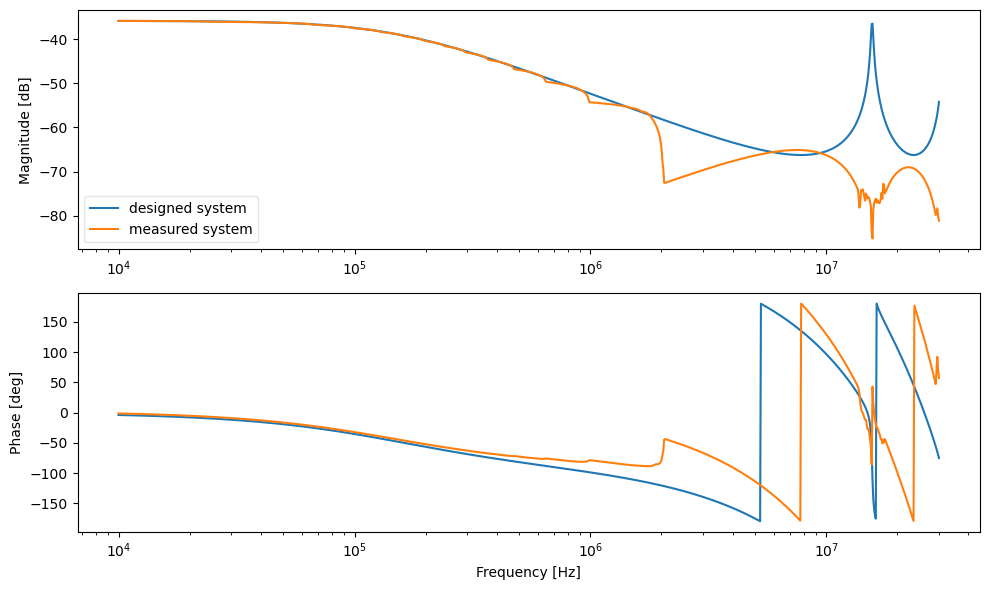

In [41]:
from pyrpl.hardware_modules.iir.iir_theory import bodeplot
bodeplot([(na.frequencies, designdata, 'designed system'),
          (na.frequencies, tf, 'measured system')], xlog=True)

Notice that the new transfer function looks a lot cleaner than the original because the sampling frequency is higher.